In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Synthetic core and lithosphere with tapered ensembles as prior"
nb_name = "nb_case_separation_synthetic"

# Lithosphere

In [2]:
shc_g = 60
shc_grid = 60

lith = SDSS(comment, N_SH = shc_g, sim_type = "lith_ens", sat_height = 350)

lith.grid_glq(nmax = shc_grid, r_at = lith.a)

grid_in = np.array([lith.grid_phi, 90-lith.grid_theta]).T
lith.make_grid(lith.a, grid_in, calc_sph_d = False)
lith.generate_map()

#lith.condtab(normsize=10000, quantiles = 1000, 
#             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble") #model_hist = "ensemble"



All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


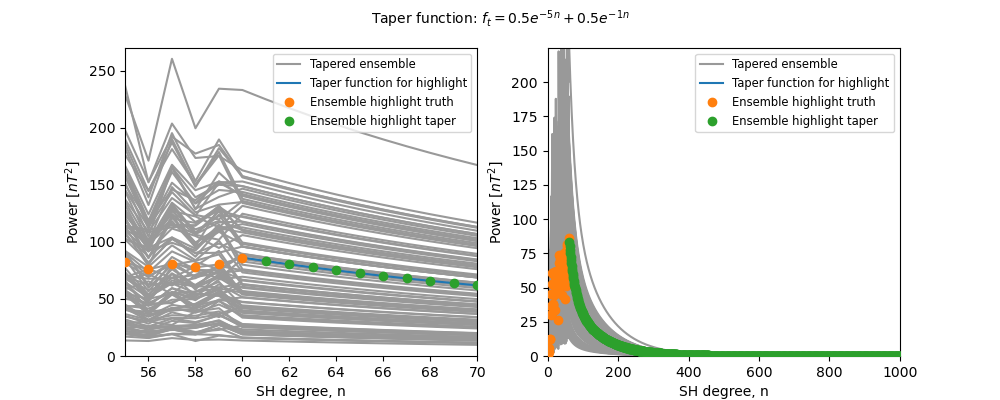

In [8]:
lith.cov_model_taper(r_at = lith.a, tap_to = 2000, tap_exp_p1 = 5, tap_exp_p2 = 1,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
                     save_fig = False, save_string = "case_lith_synthetic", save_dpi = 300)

#lith.cov_model(r_at = lith.a)

In [4]:
print(lith)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Synthetic core and lithosphere with tapered ensembles as prior
class_abs_path:   /home/mikotz/spherical_direct_sequential_simulation
N_SH:             60
N_SH_secondary:   None
sim_type:         lith_ens
grid_zero:        (61,), Max/Min: 1.00 / -1.00
grid_w_shtools:   (61,), Max/Min: 0.05 / 0.00
grid_shape:       (2,), Max/Min: 121.00 / 61.00
grid_w:           (7381,), Max/Min: 0.05 / 0.00
grid_radial:      (7381,), Max/Min: 6371.20 / 6371.20
grid_theta:       (7381,), Max/Min: 177.76 / 2.24
grid_phi:         (7381,), Max/Min: 357.02 / 0.00
grid_N:           7381
grid_nmax:        60
r_grid:           6371.2
grid:             (7381, 2)
sph_d:            None
lon:              (7381,), Max/Min: 357.02 / 0.00
lat:              (7381,), Max/Min: 87.76 / -87.76
N_grid:           7381
lit

In [6]:
g_ens = np.load("mikkel_tools/models_shc/lithosphere_g_in_rotated.npy")

g_ens = g_ens[:mt_util.shc_vec_len(lith.N_SH),:]

g_cut = g_ens[:lith.N_SH*(2+lith.N_SH),::100]

R = mt_util.lowe_shspec(lith.N_SH, lith.a, lith.a, g_cut)

R = R[:,np.mean(R,axis=0)>5]

In [7]:
R.shape

(30, 97)

<IPython.core.display.Javascript object>


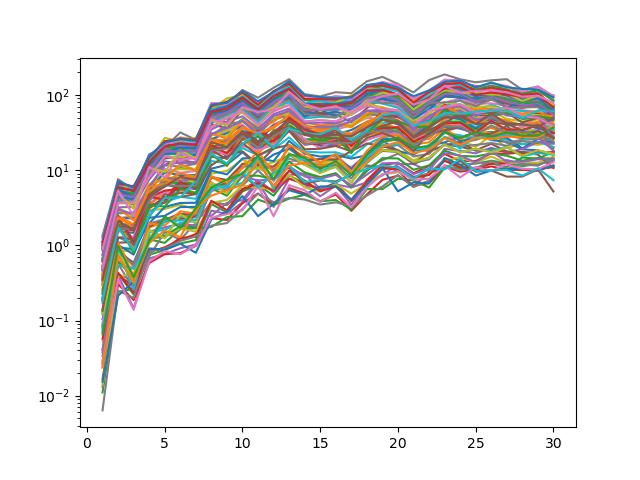

In [8]:
plt.figure()
plt.semilogy(np.arange(1,shc_g+1),R)
plt.show()

In [9]:
# Angular distance matrix
c_angdist = np.cos(mt_util.haversine(1, lith.grid_phi.reshape(1,-1), 90-lith.grid_theta.reshape(1,-1), 
                   lith.grid_phi.reshape(-1,1), 90-lith.grid_theta.reshape(-1,1)))

In [10]:
c_angdist.shape

(1891, 1891)

In [11]:
c_unique, c_return = np.unique(np.ravel(c_angdist), return_inverse = True)
c_unique.shape

(24672,)

In [12]:
c_return.shape

(3575881,)

In [13]:
# Compute covariances based on Chris' note eqn. 11
C_const = (np.arange(1,lith.N_SH+1)+1)/(2*np.arange(1,lith.N_SH+1)+1)

In [14]:
C_const.shape

(30,)

In [15]:
# Generate matrix of all required Schmidt semi-normalized legendre polynomials
Pn = []
for cmu in c_unique:
    Pn.append(pyshtools.legendre.PlSchmidt(lith.N_SH,cmu)[1:].reshape(-1,))
    
Pn = np.array(Pn)[:,:]

In [16]:
#Pn = Pn[c_return]#.reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

In [17]:
Pn.shape

(24672, 30)

In [18]:
CR = C_const.reshape(-1,1)*R
CR.shape

(30, 97)

In [17]:
C_Br = np.mean(Pn@CR,axis=1)[c_return].reshape((c_angdist.shape[0],c_angdist.shape[1]))
C_Br.shape

(13041, 13041)

In [55]:
C_Br = np.zeros((lith.grid_N, lith.grid_N, 1))
for i in np.arange(0,R.shape[1]):
    C_Br += Pn@CR[:,[i]]
    print(i)
C_Br = C_Br[:,:,0]/R.shape[1]

In [19]:
C_Br.shape

(1891, 1891)

<IPython.core.display.Javascript object>


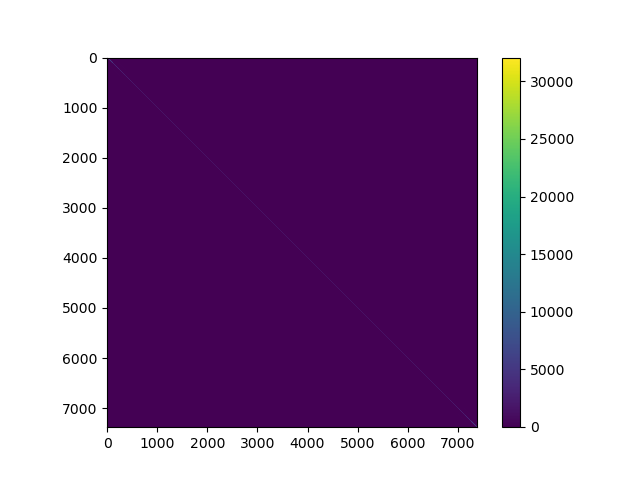

In [17]:
# old
plt.figure()
plt.imshow(lith.C_ens_tap)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


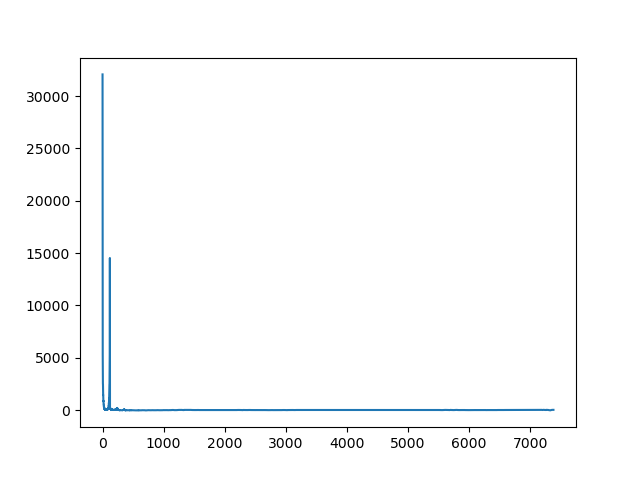

In [18]:
plt.figure()
plt.plot(lith.C_ens_tap[:,0])
plt.show()

In [29]:
shc_g = 60
shc_grid = 60

lith_truth = SDSS(comment, N_SH = shc_g, sim_type = "surface", sat_height = 350, N_SH_secondary = None)
lith_truth.grid_glq(nmax = shc_grid, r_at = lith_truth.a)
grid_in = np.array([lith_truth.grid_phi, 90-lith_truth.grid_theta]).T
lith_truth.make_grid(lith_truth.a, grid_in, calc_sph_d = False)
lith_truth.generate_map()

# Core

All eigenvalues > 0: True
Cov model is pos def: True


<IPython.core.display.Javascript object>


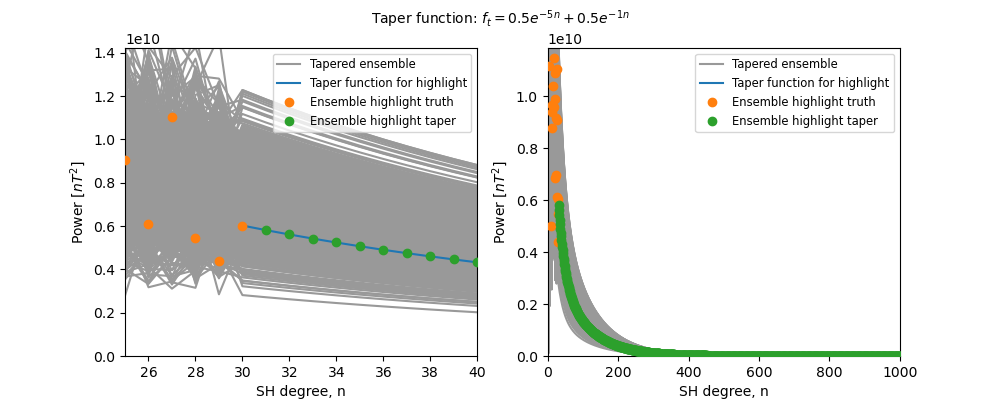

In [11]:
shc_g = 30
shc_grid = 60

core = SDSS(comment, N_SH = shc_g, sim_type = "core_ens", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = False)
core.generate_map()

#core.condtab(normsize=10000, quantiles = 1000, 
#             rangn_lim = 3.5, rangn_N = 501, rangv_lim = 2.0, rangv_N = 101, model_hist = "ensemble")

#core.cov_model_taper(r_at = core.r_cmb, tap_to = 500, tap_exp_p1 = 5, tap_exp_p2 = 2,
#                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
#                     save_fig = False, save_string = "case_core_synthetic", save_dpi = 300)

core.cov_model_taper(r_at = core.r_cmb, tap_to = 2000, tap_exp_p1 = 5, tap_exp_p2 = 1,
                     tap_scale_start = 0, tap_scale_end = 24, plot_taper = True,
                     save_fig = False, save_string = "case_core_synthetic", save_dpi = 300)

In [31]:
shc_g = 60
shc_grid = 60

core_truth = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350, N_SH_secondary = None)
core_truth.grid_glq(nmax = shc_grid, r_at = core_truth.r_cmb)
grid_in = np.array([core_truth.grid_phi, 90-core_truth.grid_theta]).T
core_truth.make_grid(core_truth.r_cmb, grid_in, calc_sph_d = False)
core_truth.generate_map()

# Synthetic observations

In [54]:
C_e_const = 10
s_sat = SDSS(comment, N_SH = shc_g, sim_type = "separation", sat_height = 350, N_SH_secondary = shc_g)
s_sat.load_swarm("ABC")
grid_in = np.array([s_sat.grid_phi, 90-s_sat.grid_theta]).T
s_sat.make_grid(s_sat.grid_radial, grid_in, calc_sph_d = False)
s_sat.generate_map(grid_type = "swarm")
s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

# Forward operators

In [14]:
lith.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = lith.C_ens_tap)
core.integrating_kernel(s_sat, C_e_const = C_e_const, C_mm_supply = core.C_ens_tap)

In [15]:
G = np.hstack((core.G,lith.G))

In [55]:
obs = s_sat.data.reshape(-1,1)

In [56]:
C_M = np.zeros((G.shape[1],G.shape[1]))

C_M[:core.C_mm_all.shape[0],:core.C_mm_all.shape[0]] = core.C_mm_all
C_M[-lith.C_mm_all.shape[0]:,-lith.C_mm_all.shape[0]:] = lith.C_mm_all

C_D = np.diag(C_e_const**2*np.ones(s_sat.grid_N,)) #core.C_dd #+ lith.C_dd

In [57]:
S = C_D + G*C_M*G.T
T = np.linalg.inv(S)
m_equiv_lsq = C_M*G.T*T*obs

In [58]:
lsq_equiv_pred = G*m_equiv_lsq
lsq_equiv_res = obs - lsq_equiv_pred

<IPython.core.display.Javascript object>


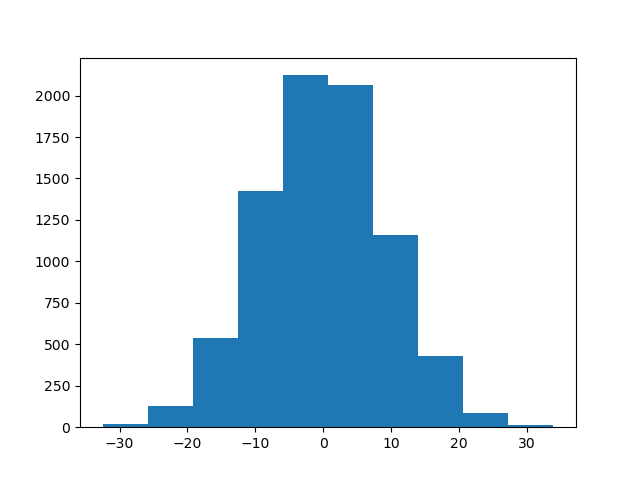

In [59]:
plt.figure()
plt.hist(lsq_equiv_res)
plt.show()

In [60]:
set_nmax_core = 60
set_nmax_lith = 60

core.grid_glq(nmax = set_nmax_core, r_at = core.r_cmb)
lith.grid_glq(nmax = set_nmax_lith, r_at = lith.a)

g_lsq_core, _ = mt_util.sh_expand_glq(m_equiv_lsq[:core.grid_N], core.grid_nmax, core.grid_w_shtools, 
                                      core.grid_zero, set_nmax_core, geomag_r_at = core.r_cmb)

g_lsq_lith, _ = mt_util.sh_expand_glq(m_equiv_lsq[core.grid_N:], lith.grid_nmax, lith.grid_w_shtools, 
                                      lith.grid_zero, set_nmax_lith, geomag_r_at = lith.a)

In [61]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
core.ensemble_B(g_lsq_core, nmax = set_nmax_core, r_at = core.r_cmb, grid_type = "glq")
m_lsq_core = core.B_ensemble[:,0].copy()

lith.grid_glq(nmax = 256, r_at = lith.a)
lith.ensemble_B(g_lsq_lith, nmax = set_nmax_lith, r_at = lith.a, grid_type = "glq")
m_lsq_lith = lith.B_ensemble[:,0].copy()

core_truth.grid_glq(nmax = 256, r_at = core_truth.r_cmb)
core_truth.ensemble_B(core_truth.g_prior, nmax = 60, r_at = core_truth.r_cmb, grid_type = "glq")
m_core_truth = core_truth.B_ensemble[:,0].copy()

lith_truth.grid_glq(nmax = 256, r_at = lith_truth.r_cmb)
lith_truth.ensemble_B(lith_truth.g_prior, nmax = set_nmax_lith, r_at = lith_truth.a, grid_type = "glq")
m_lith_truth = lith_truth.B_ensemble[:,0].copy()

<IPython.core.display.Javascript object>


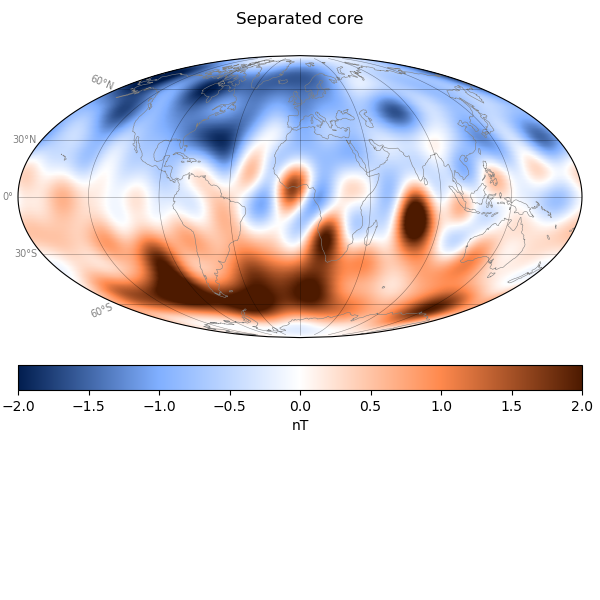

<IPython.core.display.Javascript object>


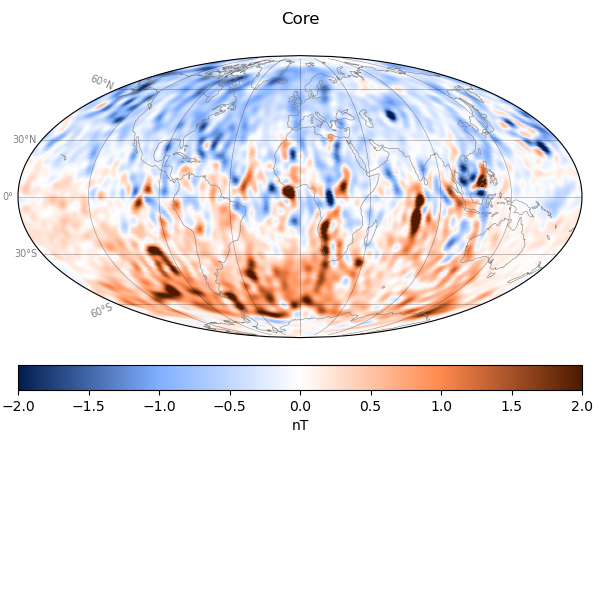

In [62]:
mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=m_lsq_core, limits_data = [-2,2],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Separated core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_core",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-core.grid_theta, lon = core.grid_phi, data=m_core_truth, limits_data = [-2,2],
                cbar_h = 0.075, unit_transform_n_to_m = True,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Core', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_core",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

core.grid_glq(nmax = set_nmax_core, r_at = core.r_cmb)
core_truth.grid_glq(nmax = set_nmax_core, r_at = core_truth.r_cmb)

<IPython.core.display.Javascript object>


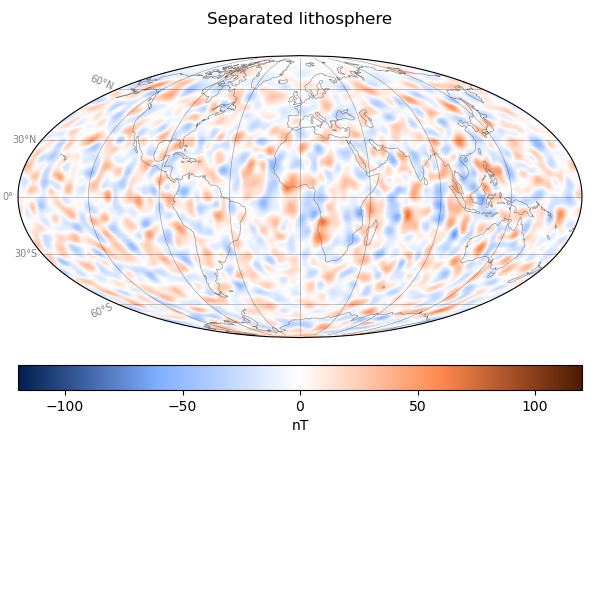

<IPython.core.display.Javascript object>


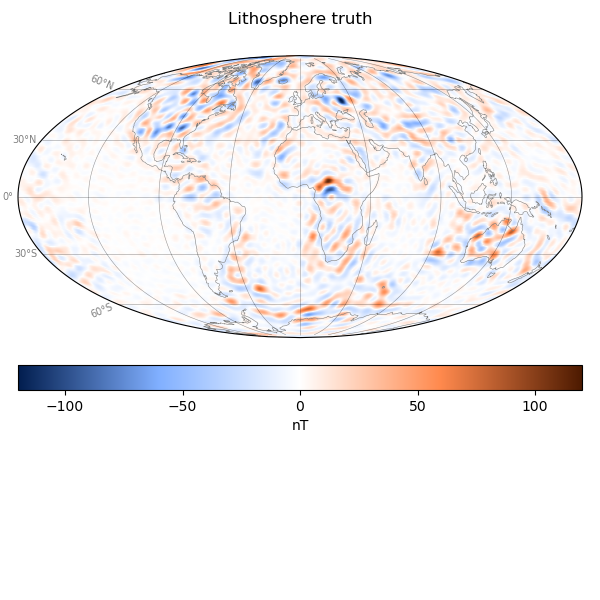

In [63]:
mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=m_lsq_lith, limits_data = [-120,120],
                cbar_h = 0.075, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Separated lithosphere', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

mt_util.plot_global(lat = 90-lith.grid_theta, lon = lith.grid_phi, data=m_lith_truth, limits_data = [-120,120],
                cbar_h = 0.075, unit_transform_n_to_m = False,
                cbar_text = "nT", figsize=(6,6), coast_width = 0.4,
                bottom=0.35, top=0.95, hspace=0.01,
                title='Lithosphere truth', point_size=1,
                savefig = False, save_dpi = 100, save_string ="case_separate_lith",
                use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4)

lith.grid_glq(nmax = set_nmax_lith, r_at = lith.a)
lith_truth.grid_glq(nmax = set_nmax_lith, r_at = lith_truth.a)

# SDSSIM

In [ ]:
N_sim = 6
lith.target_var = np.max(lith.C_ens_tap)

lith.run_sim(N_sim, lith.grid_N, lith.C_mm_all, lith.C_dd, lith.C_dm_all, lith.G,
        s_sat.data, lith.data, scale_m_i = True, unit_d = False, collect_all = True,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False, solve_cho = True)

 |OOOOOOOOO-| 97.4%   realization nr. 0. Counter: 1842/1891, Running error magnitude: 1.0

In [ ]:
lith.realization_to_sh_coeff(lith.r_cmb, set_nmax = shc_grid)

In [ ]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

#truth_obj = s_source

lith.grid_glq(nmax = shc_grid, r_at = lith.a)
mt_util.plot_sdssim_reproduce(lith, lith.m_DSS_res, m_equiv_lsq = None, truth_obj = s_source,
                              lags_use = 1000, spec_r_at = lith.r_cmb, spec_show_differences = False,
                              spec_ti_ens = True, lwidth = .5, label_fontsize = "small",
                              res_use = True, sv_use = False, unit_field = "[mT]",
                              unit_transform_n_to_m = True, patch_legend = True, ens_prior = True,
                              model_dict = {}, figsize=(9,16), hist_ti_ens = False, hist_density = True,
                              hist_bins = 41, res_bins = 21, hist_pos_mean = False,
                              left=0.08, bottom=0.12, right=0.92, top=0.95, wspace = 0.2, hspace=0.25,
                              savefig = False, save_string = "case_lith_synthetic", save_dpi = 300)

In [12]:
#core.pickle_save_self(nb_name)


Saving job

Job saved and finished


In [13]:
#core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)
core.grid_glq(nmax = 400, r_at = core.r_cmb)

set_nmax = shc_grid

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
core.ensemble_B(s_sat.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble[:,0].copy()

#core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
#lsq_eqa = core.B_ensemble[:,0].copy()

In [ ]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_phi, 90-core.grid_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = None, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1, cbar_limit = [-1.6,1.6],
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.25, 
                        savefig = False, save_string = "case_core_synthetic", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)
